
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd

In [2]:
alphas = []
llambdas = []
times = []
sharpes = []
turnovers = []

for alpha in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.95, 0.99]:
    for llambda in [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 15, 20, 25, 40, 50, 75, 100]:

        adjClose = pd.read_csv("MIE377_AssetPrices2.csv", index_col=0)
        factorRet = pd.read_csv("MIE377_FactorReturns1.csv", index_col=0)

        adjClose.index = pd.to_datetime(adjClose.index)
        factorRet.index = pd.to_datetime(factorRet.index)

        # Initial budget to invest ($100,000)
        initialVal = 100000

        # Length of investment period (in months)
        investPeriod = 6

        # divide the factor returns by  100
        factorRet = factorRet/100

        #rf and factor returns
        riskFree = factorRet['RF']
        factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

        #Identify the tickers and the dates
        tickers = adjClose.columns
        dates   = factorRet.index

        # Calculate the stocks monthly excess returns
        # pct change and drop the first null observation
        returns = adjClose.pct_change(1).iloc[1:, :]


        returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
        # Align the price table to the asset and factor returns tables by discarding the first observation.
        adjClose = adjClose.iloc[1:,:]

        assert adjClose.index[0] == returns.index[0]
        assert adjClose.index[0] == factorRet.index[0]

        # Start of out-of-sample test period
        testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

        #End of the first investment period
        testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

        # End of calibration period
        calEnd = testStart -  pd.offsets.DateOffset(days = 1)

        # Total number of investment periods
        NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

        # Number of assets
        n  = len(tickers)

        # Preallocate space for the portfolio weights (x0 will be used to calculate
        # the turnover rate)
        x  = np.zeros([n, NoPeriods])
        x0 = np.zeros([n, NoPeriods])

        # Preallocate space for the portfolio per period value and turnover
        currentVal = np.zeros([NoPeriods, 1])
        turnover   = np.zeros([NoPeriods, 1])

        #Initiate counter for the number of observations per investment period
        toDay = 0

        # Measure runtime: start the clock
        start_time = time.time()

        # Empty list to measure the value of the portfolio over the period
        portfValue = []

        for t in range(NoPeriods):
            # Subset the returns and factor returns corresponding to the current calibration period.
            periodReturns = returns[returns.index <= calEnd]
            periodFactRet = factorRet[factorRet.index <= calEnd]

            current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
            currentPrices = adjClose[current_price_idx]

            # Subset the prices corresponding to the current out-of-sample test period.
            periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
            periodPrices = adjClose[periodPrices_idx]

            assert len(periodPrices) == investPeriod
            assert len(currentPrices) == 1
            # Set the initial value of the portfolio or update the portfolio value
            if t == 0:
                currentVal[0] = initialVal
            else:
                currentVal[t] = currentPrices @  NoShares.values.T
                #Store the current asset weights (before optimization takes place)
                x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

            #----------------------------------------------------------------------
            # Portfolio optimization
            # You must write code your own algorithmic trading function
            #----------------------------------------------------------------------
            x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], alpha, llambda)

            #Calculate the turnover rate
            if t > 0:
                turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

            # Number of shares your portfolio holds per stock
            NoShares = x[:,t]*currentVal[t]/currentPrices

            # Update counter for the number of observations per investment period
            fromDay = toDay
            toDay   = toDay + len(periodPrices)

            # Weekly portfolio value during the out-of-sample window
            portfValue.append(periodPrices@ NoShares.values.T)

            # Update your calibration and out-of-sample test periods
            testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
            testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
            calEnd    = testStart - pd.offsets.DateOffset(days=1)

        portfValue = pd.concat(portfValue, axis = 0)
        end_time = time.time()

        #--------------------------------------------------------------------------
        # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
        #-----------------------------------------------------------------------
        # Calculate the observed portfolio returns
        portfRets = portfValue.pct_change(1).iloc[1:,:]

        # Calculate the portfolio excess returns
        portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

        # Calculate the portfolio Sharpe ratio
        SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

        # Calculate the average turnover rate
        avgTurnover = np.mean(turnover[1:])

        #Print Sharpe ratio and Avg. turnover to the console
        print('alpha:', alpha)
        print('lambda:', llambda)
        print("Elasped time is "+ str(end_time - start_time) + ' seconds')
        print('Sharpe ratio: ', str(SR[0]))
        print('Avg. turnover: ', str(avgTurnover))
        print('\n')

        alphas.append(alpha)
        llambdas.append(llambda)
        times.append(end_time - start_time)
        sharpes.append(SR[0])
        turnovers.append(avgTurnover)

alpha: 0.01
lambda: 0
Elasped time is 0.5109758377075195 seconds
Sharpe ratio:  0.5874557767065319
Avg. turnover:  0.17151865816594905


alpha: 0.01
lambda: 0.05
Elasped time is 0.36994361877441406 seconds
Sharpe ratio:  0.5875114395302939
Avg. turnover:  0.16048430405967312


alpha: 0.01
lambda: 0.1
Elasped time is 0.42312145233154297 seconds
Sharpe ratio:  0.5868809203372041
Avg. turnover:  0.15389769547548998


alpha: 0.01
lambda: 0.2
Elasped time is 0.4690580368041992 seconds
Sharpe ratio:  0.5832030806055736
Avg. turnover:  0.16649573004750343


alpha: 0.01
lambda: 0.3
Elasped time is 0.474884033203125 seconds
Sharpe ratio:  0.5744185724126506
Avg. turnover:  0.21586770389438406


alpha: 0.01
lambda: 0.4
Elasped time is 0.46159934997558594 seconds
Sharpe ratio:  0.5593716382662156
Avg. turnover:  0.2874244128970972


alpha: 0.01
lambda: 0.5
Elasped time is 0.4066135883331299 seconds
Sharpe ratio:  0.5402232732266917
Avg. turnover:  0.36272249179303057


alpha: 0.01
lambda: 1
Elasp

In [3]:
df = pd.DataFrame({'alpha': alphas, 'lambda': llambdas,
                   'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers})
df

,alpha,lambda,Time,Sharpe Ratio,Turnover
0,0.01,0.00,0.510976,0.587456,0.171519
1,0.01,0.05,0.369944,0.587511,0.160484
2,0.01,0.10,0.423121,0.586881,0.153898
3,0.01,0.20,0.469058,0.583203,0.166496
4,0.01,0.30,0.474884,0.574419,0.215868
...,...,...,...,...,...
195,0.99,25.00,0.460544,-0.023288,0.697970
196,0.99,40.00,0.422905,-0.080458,0.600000
197,0.99,50.00,0.449939,-0.080092,0.600000
198,0.99,75.00,0.464852,-0.080097,0.600000


In [11]:
print(np.mean(df[df['lambda'] <= 1]['Sharpe Ratio'].values))
print(np.mean(df[df['lambda'] <= 1]['Turnover'].values))

0.5666368422494423
0.23471252849108798


In [4]:
for a in sorted(list(set(alphas))):
    sub_df = df[df['alpha'] == a]
    display(sub_df)

,alpha,lambda,Time,Sharpe Ratio,Turnover
0,0.01,0.00,0.510976,0.587456,0.171519
1,0.01,0.05,0.369944,0.587511,0.160484
2,0.01,0.10,0.423121,0.586881,0.153898
3,0.01,0.20,0.469058,0.583203,0.166496
4,0.01,0.30,0.474884,0.574419,0.215868
5,0.01,0.40,0.461599,0.559372,0.287424
6,0.01,0.50,0.406614,0.540223,0.362722
7,0.01,1.00,0.471013,0.432888,0.631238
8,0.01,2.00,0.418970,0.195429,0.745706
9,0.01,3.00,0.425307,0.088861,0.832185


,alpha,lambda,Time,Sharpe Ratio,Turnover
20,0.05,0.00,0.357044,0.587225,0.171182
21,0.05,0.05,0.458175,0.587304,0.160900
22,0.05,0.10,0.412406,0.586819,0.154119
23,0.05,0.20,0.399994,0.583816,0.161299
24,0.05,0.30,0.366974,0.577072,0.199079
25,0.05,0.40,0.388553,0.565045,0.263971
26,0.05,0.50,0.548693,0.549144,0.328540
27,0.05,1.00,0.452055,0.446703,0.614320
28,0.05,2.00,0.373003,0.224959,0.695799
29,0.05,3.00,0.398480,0.112024,0.830692


,alpha,lambda,Time,Sharpe Ratio,Turnover
40,0.1,0.00,0.412638,0.587113,0.171021
41,0.1,0.05,0.351553,0.587202,0.161101
42,0.1,0.10,0.419592,0.586779,0.154306
43,0.1,0.20,0.472927,0.584090,0.159103
44,0.1,0.30,0.420816,0.578166,0.191957
45,0.1,0.40,0.486611,0.567339,0.251448
46,0.1,0.50,0.449292,0.552816,0.312648
47,0.1,1.00,0.399127,0.455772,0.598901
48,0.1,2.00,0.406662,0.237878,0.673841
49,0.1,3.00,0.428234,0.121221,0.838438


,alpha,lambda,Time,Sharpe Ratio,Turnover
60,0.2,0.00,0.418895,0.586990,0.170840
61,0.2,0.05,0.472252,0.587085,0.161335
62,0.2,0.10,0.363301,0.586727,0.154625
63,0.2,0.20,0.368206,0.584388,0.156758
64,0.2,0.30,0.486335,0.579283,0.184397
65,0.2,0.40,0.595122,0.569858,0.237255
66,0.2,0.50,0.562001,0.556428,0.295953
67,0.2,1.00,0.421943,0.467278,0.575755
68,0.2,2.00,0.459088,0.253750,0.657314
69,0.2,3.00,0.414937,0.133520,0.844188


,alpha,lambda,Time,Sharpe Ratio,Turnover
80,0.3,0.00,0.397952,0.586907,0.170720
81,0.3,0.05,0.360027,0.587005,0.161497
82,0.3,0.10,0.389810,0.586689,0.154837
83,0.3,0.20,0.400610,0.584571,0.155517
84,0.3,0.30,0.422622,0.579949,0.179729
85,0.3,0.40,0.406305,0.571452,0.228259
86,0.3,0.50,0.400897,0.559284,0.285487
87,0.3,1.00,0.384577,0.474141,0.561355
88,0.3,2.00,0.424759,0.272997,0.651405
89,0.3,3.00,0.404860,0.143014,0.838116


,alpha,lambda,Time,Sharpe Ratio,Turnover
100,0.4,0.00,0.382859,0.586841,0.170625
101,0.4,0.05,0.382260,0.586943,0.161644
102,0.4,0.10,0.384910,0.586654,0.155023
103,0.4,0.20,0.376961,0.584704,0.154553
104,0.4,0.30,0.378711,0.580459,0.176395
105,0.4,0.40,0.395446,0.572755,0.221052
106,0.4,0.50,0.372971,0.561378,0.277069
107,0.4,1.00,0.390230,0.479090,0.550422
108,0.4,2.00,0.394789,0.290311,0.648420
109,0.4,3.00,0.404173,0.149955,0.825598


,alpha,lambda,Time,Sharpe Ratio,Turnover
120,0.5,0.00,0.333222,0.586781,0.170540
121,0.5,0.05,0.390608,0.586886,0.161775
122,0.5,0.10,0.357023,0.586623,0.155191
123,0.5,0.20,0.378446,0.584814,0.153760
124,0.5,0.30,0.357882,0.580893,0.173651
125,0.5,0.40,0.366627,0.573792,0.214718
126,0.5,0.50,0.345747,0.563008,0.269677
127,0.5,1.00,0.413647,0.483281,0.541276
128,0.5,2.00,0.420238,0.304848,0.644009
129,0.5,3.00,0.381165,0.155736,0.815069


,alpha,lambda,Time,Sharpe Ratio,Turnover
140,0.9,0.00,0.511777,0.586517,0.170175
141,0.9,0.05,0.449385,0.586633,0.162358
142,0.9,0.10,0.496876,0.586471,0.156038
143,0.9,0.20,0.450252,0.585211,0.151376
144,0.9,0.30,0.442837,0.582504,0.163364
145,0.9,0.40,0.498743,0.577689,0.190464
146,0.9,0.50,0.614677,0.570053,0.233383
147,0.9,1.00,0.507708,0.501506,0.490877
148,0.9,2.00,0.506908,0.366716,0.630419
149,0.9,3.00,0.470970,0.188576,0.761134


,alpha,lambda,Time,Sharpe Ratio,Turnover
160,0.95,0.00,0.407229,0.586453,0.170086
161,0.95,0.05,0.351576,0.586570,0.162500
162,0.95,0.10,0.369469,0.586428,0.156313
163,0.95,0.20,0.452198,0.585286,0.151101
164,0.95,0.30,0.394608,0.582777,0.161249
165,0.95,0.40,0.362583,0.578486,0.185189
166,0.95,0.50,0.385627,0.571617,0.224719
167,0.95,1.00,0.473026,0.508505,0.475097
168,0.95,2.00,0.437940,0.379860,0.628881
169,0.95,3.00,0.459418,0.201205,0.737443


,alpha,lambda,Time,Sharpe Ratio,Turnover
180,0.99,0.00,0.504955,0.586337,0.169930
181,0.99,0.05,0.411613,0.586460,0.162773
182,0.99,0.10,0.462546,0.586352,0.156832
183,0.99,0.20,0.484660,0.585398,0.150837
184,0.99,0.30,0.473779,0.583266,0.157873
185,0.99,0.40,0.438728,0.579701,0.177035
186,0.99,0.50,0.426893,0.574059,0.210127
187,0.99,1.00,0.450658,0.519373,0.442074
188,0.99,2.00,0.441840,0.401740,0.627811
189,0.99,3.00,0.425051,0.225622,0.695631


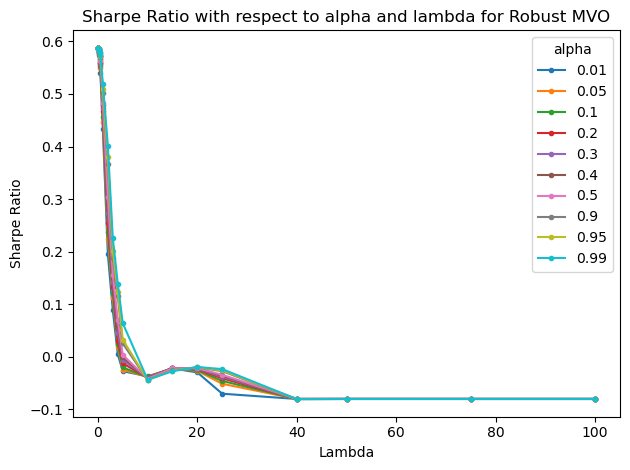

In [5]:
fig, ax1 = plt.subplots()
plt.title('Sharpe Ratio with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Sharpe Ratio')

for a in sorted(list(set(alphas))):
    sub_df = df[df['alpha'] == a]
    ax1.plot(sub_df['lambda'].values, sub_df['Sharpe Ratio'].values, label=str(a), marker='.')

ax1.legend(title='alpha')
plt.tight_layout()
plt.show()

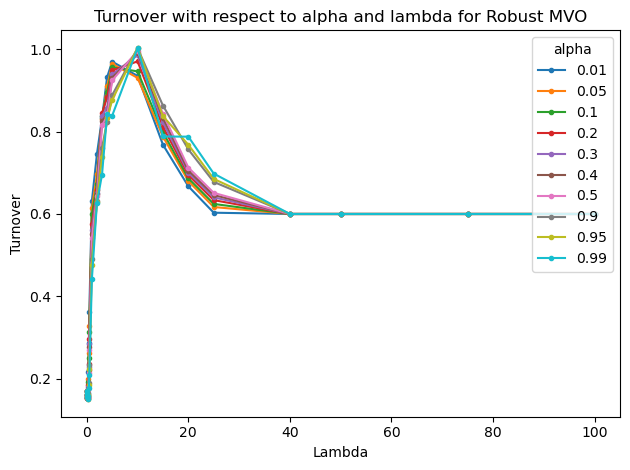

In [6]:
fig, ax1 = plt.subplots()
plt.title('Turnover with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Turnover')

for a in sorted(list(set(alphas))):
    sub_df = df[df['alpha'] == a]
    ax1.plot(sub_df['lambda'].values, sub_df['Turnover'].values, label=str(a), marker='.')

ax1.legend(title='alpha')
plt.tight_layout()
plt.show()

In [7]:
import seaborn as sns

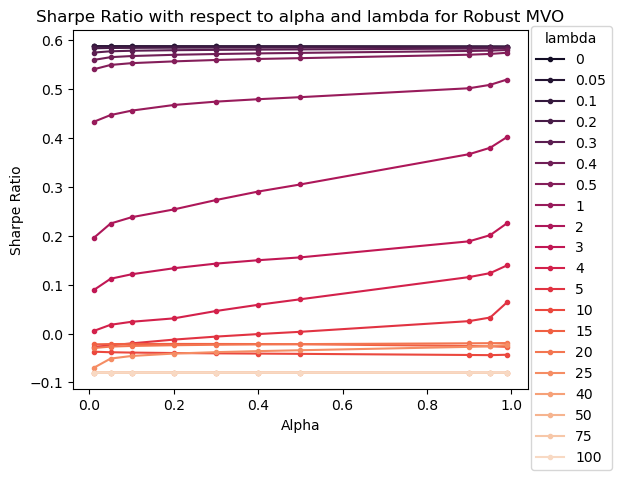

In [8]:
fig, ax1 = plt.subplots()
plt.title('Sharpe Ratio with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Sharpe Ratio')

clrs = sns.color_palette('rocket', n_colors=20)

i = 0
for l in sorted(list(set(llambdas))):
    sub_df = df[df['lambda'] == l]
    ax1.plot(sub_df['alpha'].values, sub_df['Sharpe Ratio'].values, label=str(l), marker='.', color=clrs[i])
    i += 1

ax1.legend(title='lambda', bbox_to_anchor=(1.2, 1.03))
plt.tight_layout()
plt.show()

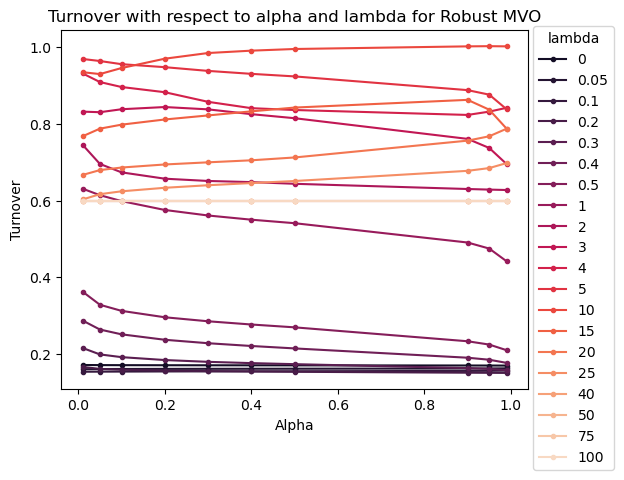

In [9]:
fig, ax1 = plt.subplots()
plt.title('Turnover with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Turnover')

clrs = sns.color_palette('rocket', n_colors=20)

i = 0
for l in sorted(list(set(llambdas))):
    sub_df = df[df['lambda'] == l]
    ax1.plot(sub_df['alpha'].values, sub_df['Turnover'].values, label=str(l), marker='.', color=clrs[i])
    i += 1

ax1.legend(title='lambda', bbox_to_anchor=(1.2, 1.03))
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

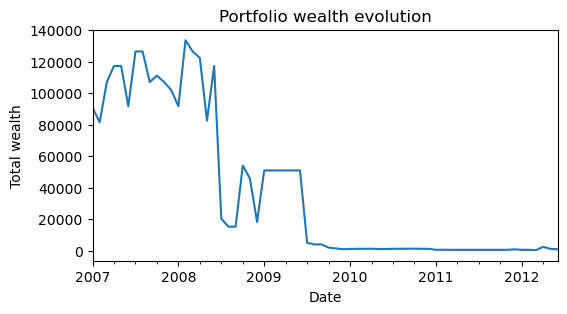

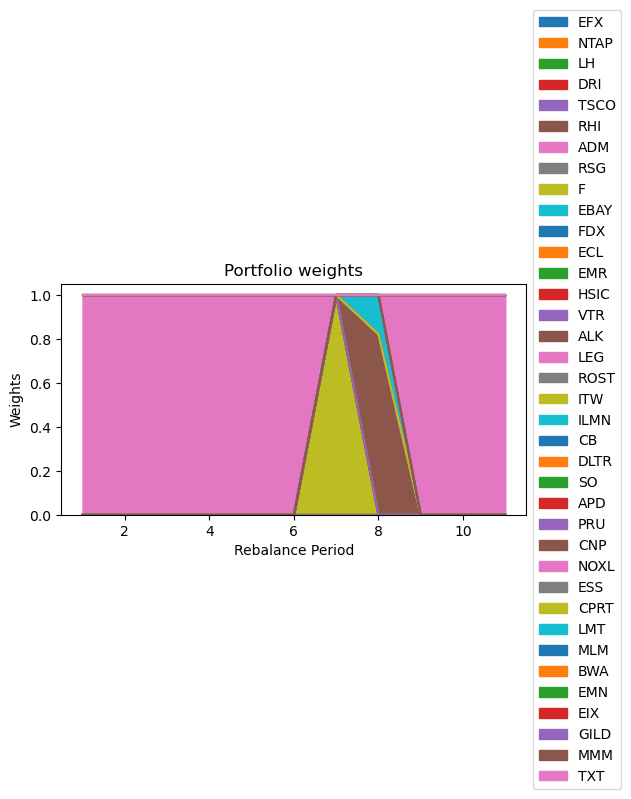

In [10]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%